In [15]:
import numpy as np
import pandas as pd
# from sklearn.preprocessing import OneHotEncoder,LabelEncoder
# from sklearn.ensemble import GradientBoostingClassifier,IsolationForest
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,  roc_auc_score,precision_score,recall_score
# from scipy.sparse import hstack
import seaborn as sns
# from collections import Counter
# from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import time
import gc
import xgboost as xgb
from xgboost import plot_importance
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
sns.set(font='SimHei')  # 解决Seaborn中文显示问题
import warnings
warnings.filterwarnings("ignore")
import tools.explore
import tools.missing_data as ms
import tools.outlier as ot
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [2]:
def Del_string(xstr):
    xstrc = xstr.strip().strip("市").strip("省")
    if(xstrc == ""):
        xstrc = np.nan
    return(xstrc)

In [3]:
par_csv = dict(index_col = 0, encoding = "GB18030", parse_dates = ["ListingInfo"], na_values = [-1], 
               converters = dict(zip(*[["UserInfo_{}".format(i) for i in [9, 2, 4, 8, 20, 7, 19]], [Del_string]*7])))

df=pd.read_csv('./Training Set/PPD_Training_Master_GBK_3_1_Training_Set.csv',**par_csv)
# df_test=pd.read_csv('./Test Set/PPD_Master_GBK_2_Test_Set.csv',**par_csv)


In [4]:
df.shape

(30000, 227)

In [5]:
# 对数值型变量，计算单变量的标准差，删除小于0.1的特征
# df.drop(list((df[num_var_list].std())[df[num_var_list].std()<0.1].index.values),axis=1) 取而代之
time_start=time.time()
l=[]
for i in df.select_dtypes(['int64','float64']).columns[1:]:
    if np.std(df[i])<0.1:
        print('%s标准差：' %i,np.std(df[i]))
        l.append(i)
    if df[i].isnull().mean()>0.99:
        print('%s缺失率：' %i,df[i].isnull().mean())
        l.append(i)
df=df.drop(list(set(l)),axis=1)
time_end=time.time()
print('time cost：',time_end-time_start,'s')
del l
gc.collect()

WeblogInfo_10标准差： 0.0
WeblogInfo_23标准差： 0.08747391234437821
WeblogInfo_31标准差： 0.08375465689794662
WeblogInfo_32标准差： 0.07908268872845749
WeblogInfo_40标准差： 0.07049648343800485
WeblogInfo_41标准差： 0.020080818970862818
WeblogInfo_43标准差： 0.0393032132530723
WeblogInfo_44标准差： 0.015338268242815535
WeblogInfo_46标准差： 0.028979700901037787
WeblogInfo_47标准差： 0.04217794354303182
WeblogInfo_49标准差： 0.0
WeblogInfo_52标准差： 0.05192917184867923
WeblogInfo_55标准差： 0.03650607255421587
WeblogInfo_58标准差： 0.06345391153339283
SocialNetwork_1标准差： 0.0369478761981756
SocialNetwork_11缺失率： 0.9996
SocialNetwork_12标准差： 0.0983541762614148
time cost： 0.20817303657531738 s


29

In [6]:
df.shape

(30000, 210)

In [7]:
# 地址特征转换
for i in [2, 4, 8, 20, 7, 19]:
    df.loc[:,'UserInfo_{}'.format(i)]=df.loc[:,'UserInfo_{}'.format(i)].str.replace('新疆维吾尔自治区','新疆维吾尔')
# 针对地址特征构建一些是否相等(0/1)的新特征
for i in [2,4,8,20]:
    for j in [2,4,8,20]:
        if j>i:
            t=(df.loc[:,'UserInfo_{}'.format(i)]==df.loc[:,'UserInfo_{}'.format(j)])+0
            t.name='UserInfo_{}_{}'.format(i,j)
            df=pd.concat([df,t],axis=1)
for i in [7,19]:
    for j in [7,19]:
        if j>i:
            t=(df.loc[:,'UserInfo_{}'.format(i)]==df.loc[:,'UserInfo_{}'.format(j)])+0
            t.name='UserInfo_{}_{}'.format(i,j)
            df=pd.concat([df,t],axis=1)

In [8]:
df.shape

(30000, 217)

In [9]:
str_var_list, num_var_list, all_var_list=explore.get_dtypes(df)

In [10]:
# 针对不同缺失数的特征分别进行相关性检验,并删除相关系数大于0.99的其中一个特征
msd=ms.check_missing(data=df[num_var_list]).sort_values(by='total missing')
cutd=(pd.cut(msd.proportion,3))
l=[]
for i in cutd.values.unique():
    df=df.drop(df.loc[:,list(cutd[cutd==i].index)].columns[np.any(np.abs(np.tril(df.loc[:,list(cutd[cutd==i].index)].corr(),-1))>0.99, axis = 0)],axis=1)
del l
gc.collect()


0

In [11]:
df.shape

(30000, 215)

In [12]:
# # 离群点 
# for i in list(df_t.columns)[:-1]:
#     p=np.percentile(df_t[i].fillna(0), 99.99999)
#     df.drop(df[df[i] > p].index, inplace=True)

In [13]:
# 随机数设置，确保模型效果可复现
import os 
import random
def seed_everything(seed=15):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learn_rate=0.01, learning_rate=0.300000012, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

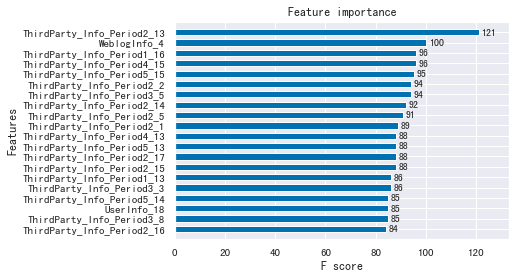

NameError: name 'pickle' is not defined

In [14]:
# 用xgboost模型找出最重要的前20个特征 

#X=df.drop(['target','Idx','ListingInfo','UserInfo_4','UserInfo_8','UserInfo_20','UserInfo_26','UserInfo_19','UserInfo_25'],axis=1)
num_var_list2=num_var_list[:]
num_var_list2.remove('target')
X=df.loc[:,num_var_list2]
# X=df.drop(['target','ListingInfo'],axis=1)
y=df['target']
seed_everything()
model_xgb_importance = xgb.XGBClassifier(max_depth=5, n_estimators=300, learn_rate=0.01)
model_xgb_importance.fit(X, y) 

plot_importance(model_xgb_importance,max_num_features=20,height=0.6,importance_type='weight')
# 具体表示出来
# sorted( model.get_booster().get_score().items(), key=lambda x:x[1],reverse=True)
plt.show()
# 找出异常点，若一个样本在前20重要的特征中缺失了50%以上，则认为该样本是异常点，予以剔除
pickle.dump(model_xgb_importance, open("./output/model_xgb_importance.dat", "wb"))




In [18]:
# 找出异常点，若一个样本在前20重要的特征中缺失了50%以上，则认为该样本是异常点，予以剔除
# l存放前20重要的特征
l=[]
for i in sorted( model_xgb_importance.get_booster().get_score().items(), key=lambda x:x[1],reverse=True)[0:20]:
    l.append(i[0])
# (df[l].isna().sum(axis=1))[df[l].isna().sum(axis=1)>10]
print('{} lines before drop'.format(df.shape[0]))
df.drop((df[l].isna().sum(axis=1))[df[l].isna().sum(axis=1)>10].index,inplace=True)
print('{} lines after drop'.format(df.shape[0]))

30000 lines before drop
29690 lines after drop


In [19]:
df.to_hdf("./output/PPD_df.h5", key = "dah", complib = "zlib", complevel = 1, mode = "w")

In [20]:
def Read_History(file, icid, ictime, par_csv = {}):
    '''Organize Time-Dependent Historical Records
    
    Parameters
    ----------
    file: a list of file name
    icid: column name of id
    ictime: a list of 2 column names: [basetime, recordtime]
    par_csv: other parameters for pd.read_csv
    '''
    par = {"parse_dates": ictime}
    par.update(par_csv)
    dah = pd.read_csv(file, **par)
    dahb = (dah.assign(Id = dah[icid], Time = (dah[ictime[1]] - dah[ictime[0]]).astype('timedelta64[D]')).set_index(["Id", "Time"])
            .drop([icid]+ictime, axis = 1).sort_index())
    return(dahb)

In [21]:
df_loginfo = Read_History(file = "Training Set/PPD_LogInfo_3_1_Training_Set.csv",
                      icid = 'Idx', ictime = ['Listinginfo1', 'LogInfo3'])
df_Userupdate_Info = Read_History(file = "Training Set/PPD_Userupdate_Info_3_1_Training_Set.csv",icid = 'Idx', ictime = ['ListingInfo1', 'UserupdateInfo2'],par_csv = {"converters": {"UserupdateInfo1": lambda x: x.lower()}})
df_loginfo.to_hdf("PPD_df_loginfo.h5", key = "dah", complib = "zlib", complevel = 1, mode = "w")
df_Userupdate_Info.to_hdf("PPD_df_Userupdate_Info.h5", key = "dah", complib = "zlib", complevel = 1, mode = "w")

In [22]:
def Clean_history(dah, iccat, name):
    grp1 = dah.reset_index()[["Id", "Time"]].groupby("Id")
    grp2 = dah.groupby(level = ["Id", "Time"]).first().reset_index()[["Id", "Time"]].groupby("Id")
    dahc1 = pd.concat([grp1.first(), grp1.count()], axis = 1, ignore_index = True).rename(columns = {0:"FirstTime", 1:"Count"})
    dahc1 = dahc1.assign(DayFreq = grp2.count()["Time"]/(1-dahc1["FirstTime"])).loc[df.index]
    dahc2 = dah.reset_index().groupby(["Id"]+iccat).count().unstack(iccat)["Time"].loc[df.index]
    dahc = pd.concat([dahc1, pd.DataFrame({"Cats": dahc2.notnull().sum(axis = 1)}), dahc2], axis = 1).fillna(0)
    dahc.columns = ["{}_{}".format(name, x) for x in dahc.columns]
    return(dahc)

In [23]:
df_loginfoc = Clean_history(df_loginfo, list(df_loginfo.columns), name = "Log")
df_Userupdate_Infoc = Clean_history(df_Userupdate_Info, list(df_Userupdate_Info.columns), name = "Userupdate")
da = pd.concat([df, df_loginfoc, df_Userupdate_Infoc], axis = 1)
da.shape
# 用重要特征的缺失率删除离群点后 (29690, 338)

(29690, 338)

In [24]:
da.to_hdf("./output/PPD_da.h5", key = "dah", complib = "zlib", complevel = 1, mode = "w")

In [25]:
# 记录数据的字段类型 将原始数值类型中不同值个数小于10的标记为Categorical
t=pd.concat(map(lambda i:pd.DataFrame(['Categorical' if i in da.select_dtypes('float64','int64') and len(da.loc[:,i].unique())<10 else da.loc[:,i].dtypes]),da.columns),ignore_index=True).replace(['object','O'],'Categorical').replace(['float64','int64'],'Numerical').rename(columns = {0:"columns_type"})
t.index=da.columns
t.reset_index().set_index('index')
# t.columns_type.value_counts()
t.to_csv('Training Set/PPD_daa.csv')
del t

,columns_type
index,
UserInfo_1,Categorical
UserInfo_2,Categorical
UserInfo_3,Categorical
UserInfo_4,Categorical
WeblogInfo_2,Categorical
...,...
Userupdate__turnover,Numerical
Userupdate__userid,Categorical
Userupdate__webshoptypeid,Categorical


In [26]:
def Col_group(ic, i = 0):
    cols = pd.Series([x.split("_")[i] for x in ic], index = ic)
    return(cols)
daa = pd.read_csv("Training Set/PPD_daa.csv",index_col=0)
daacity0 = pd.read_csv("Training Set/cnd_da_city_{}.csv".format(0), encoding = "GB18030", index_col = 0)
daacity1 = pd.read_csv("Training Set/cnd_da_city_{}.csv".format(1), encoding = "GB18030",
                       converters = {"Prov": Del_string, "City": Del_string, "District": Del_string})
daacity1= (pd.concat(map(lambda i: daacity1.drop_duplicates([i]).set_index([i]).iloc[:,2:], ["Prov", "City", "District"]))
            .reset_index().drop_duplicates(["index"]).set_index(["index"]))
daacity = daacity1.join(daacity0, how = "left")
ictype = {"y": ["target"],
          "date": ["ListingInfo"], 
          "catmap": ["UserInfo_{}".format(i) for i in [2, 4, 8, 20, 7, 19]],
          "catmapd": [daacity]*6,
          }
ictype["cols"] = Col_group(da.drop(ictype["y"], axis = 1).columns)
tmp = ictype["cols"].index[ictype["cols"] == "ThirdParty"]
ictype["serials"] = pd.Series(["_".join([x.split("_")[i] for i in [0,1,3]]) for x in tmp], index = tmp)
ictype["catbin"] = list((set(daa.index[daa.columns_type == "Categorical"])|set(da.columns[da.dtypes == "O"])) - set(ictype["catmap"]))

In [27]:
def Value_counts(das, nhead = 5):
    tmp = pd.value_counts(das).reset_index().rename(columns={"index": das.name})
    value = pd.DataFrame(['value {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,0], how = "left").set_index(0).T
    freq = pd.DataFrame(['freq {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,1], how = "left").set_index(0).T
    nnull = das.isnull().sum()
    freqother = pd.DataFrame({das.name: [das.shape[0]-nnull-np.nansum(freq.values), nnull]}, index = ["freq others", "freq NA"]).T
    op = pd.concat([value, freq, freqother], axis = 1)
    return(op)
def Summary(da):
    op = pd.concat([pd.DataFrame({"type": daa.columns_type, "n": da.notnull().sum(axis = 0)}), da.describe().T.iloc[:,1:], 
                    pd.concat(map(lambda i: Value_counts(da.loc[:,i]), da.columns))], axis = 1).loc[da.columns]
    op.index.name = "Columns"
    return(op)

In [28]:
Summary(da).to_csv("./output/PPD_summary_da.csv")

In [29]:
def Time_to_num(das):
    tmp = pd.DatetimeIndex(das)
    daop = pd.DataFrame(dict(zip(*[["{}_{}".format(das.name, i) for i in ["Day", "Year", "DayofYear", "DayofMonth", "DayofWeek"]], 
                                   [(das - das.min()).astype('timedelta64[D]').astype(int), tmp.year, tmp.dayofyear, tmp.day, tmp.dayofweek]])),
                        index = das.index)
    return(daop)
def Cat_map(das, damap, fillna = {"CityRank":6}):
    daop = das.reset_index().set_index([das.name]).join(damap, how = "left").set_index(das.index.name).reindex(das.index).fillna(fillna)
    daop.columns = ["{}_{}".format(das.name, i) for i in damap.columns]
    return(daop)
def Cat_to_bin(das, a = 0.01):
    '''Transfrom a categorical column to onehotencoding'''
#     dropna=False 使空值作为单独一个类别考虑
    tmp = pd.value_counts(das,dropna=False)/das.shape[0]
    cat = list(tmp.index[tmp <= a])
    #     将阈值以下的小类别全部归为一类
    if das.isna().any().sum()!=0:
        dummy_na=True
    else:
        dummy_na=False
    if len(cat)!=0:
        dabin=pd.get_dummies(das.replace(cat,'others'),dummy_na=dummy_na).drop('others',axis=1)
        dabin.columns=["{}_{}".format(das.name, x) for x in list(set(tmp.index)-set(cat))]
    else:
        dabin=pd.get_dummies(das,dummy_na=dummy_na).iloc[:,1:]
        dabin.columns=["{}_{}".format(das.name, x) for x in list(tmp.index)[1:]]
    dabin.index = das.index  
    return(dabin)
def Append_col_name(da, name):
    return(da.rename(columns = dict(zip(*[list(da.columns), ["{}_{}".format(x, name) for x in da.columns]]))))
def ColS_fillna(da, cols, f = "median", allNA = 0):
    dafill = getattr(da[cols.index].groupby(cols, axis = 1), f)()[cols]
    dafill.columns = cols.index
    daop = da[cols.index].fillna(dafill).fillna(allNA)
    return(daop)
def ColS_summary(da, cols, f = ["median", "std"]):
    grp = da[cols.index].groupby(cols, axis = 1)
    daop = pd.concat(map(lambda x: Append_col_name(getattr(grp, x)(), x), f), axis = 1)
    return(daop)
def Clean_data(da, ictype, a = 0.01):
    '''Transform and clean columns according to types'''
    dac = da.copy().replace([-np.inf, np.inf], np.nan).replace("不详", np.nan)
    dac.loc[:, "UserInfo_24"] = dac.loc[:, "UserInfo_24"].fillna('D')
    datime = pd.concat(map(lambda i: Time_to_num(dac.loc[:,i]), ictype["date"]), axis = 1)
    dacatmap = pd.concat(map(lambda i: Cat_map(dac.loc[:,ictype["catmap"][i]], ictype["catmapd"][i]), range(len(ictype["catmap"]))), axis = 1)
    dacatmap = pd.concat([dacatmap.iloc[:,15:20], ColS_summary(dacatmap, 
        pd.Series(["_".join([x.split("_")[i] for i in [0,2]]) for x in dacatmap.columns[:15]], index = dacatmap.columns[:15]))], axis = 1)
    dacatbin  = pd.concat(map(lambda i: Cat_to_bin(dac.loc[:,i], a = a), ictype["catbin"]+[ictype["catmap"][-1]]), axis = 1)
    daS = ColS_summary(dac, ictype["serials"], ["median", "std", "min", "max", "first","mean"]).fillna(0)
    cols = Col_group(daS.columns, i = -1)
    daS.loc[:,cols == "max"] = daS.loc[:,cols == "max"] - daS.loc[:,cols == "median"].values
    dacount = ColS_summary(dac, ictype["cols"], ["count"])
    dac = pd.concat([dac.drop(ictype["date"] + ictype["catmap"] + ictype["catbin"] + list(ictype["serials"].index), axis = 1), 
                     datime, dacatmap, dacatbin, daS, dacount], axis = 1)
    tmp = pd.concat(map(lambda i: Value_counts(dac.loc[:,i]), dac.columns))
    dac = dac.loc[:, (tmp["freq 1"] + tmp["freq NA"])/dac.shape[0] < 1 - a]
    dac = dac.drop(dac.columns[np.any(np.abs(np.tril(np.corrcoef(dac.rank(pct = True).fillna(0.5).values, rowvar = 0), -1)) > 0.99, axis = 0)], axis = 1)
    return(dac)

In [30]:
dac = Clean_data(da, ictype, a = 0.001)
Summary(dac).to_csv("./output/PPD_summary_dac.csv")
dac.shape
# 用重要特征的缺失率删除离群点后 (29690, 488)

(29690, 488)

In [31]:
dac.to_hdf("./output/PPD_dac.h5", key = "dah", complib = "zlib", complevel = 1, mode = "w")

In [35]:
def XGBoost(xt1, xt2, yt1, yt2, seed = 0, parmodel = {}):
    timestart = time.time()
    xyt1 = xgb.DMatrix(xt1, label = yt1, missing = np.nan)
    xyt2 = xgb.DMatrix(xt2, label = yt2, missing = np.nan)
    par = {'colsample_bylevel': 0.1, 'max_depth': 4, 'min_child_weight': 1,'eta': 0.1, "seed": 15, "objective": 'binary:logistic', 'eval_metric': 'logloss'}
    par.update(parmodel)
    par["max_depth"] = int(par["max_depth"])
    parval = [(xyt1,'train'), (xyt2,'val')]
    model = xgb.train(params = par, dtrain = xyt1, num_boost_round = 1000, evals = parval, 
                      early_stopping_rounds = int(2*np.sqrt(xt1.shape[1]/par["eta"])))
    score = roc_auc_score(yt2, model.predict(xgb.DMatrix(xt2, missing = np.nan)).flatten())
    print("score:{:.4f}".format(score))
    print("Time: {:.2f} seconds".format(time.time() - timestart))
    return(model)
str_var_list2, num_var_list2, all_var_list2=explore.get_dtypes(dac)
num_var_list2.remove('target')
dac2=dac[:]
dac2.loc[:,num_var_list2]=dac2.loc[:,num_var_list2].apply(lambda x:np.log1p(x))
seed_everything()
X=dac2.drop(['target'],axis=1)
y=dac2['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model_xgb_7879 = XGBoost(X_train, X_test, y_train, y_test, parmodel = 
                {'colsample_bylevel': 0.07, 'eta': 0.05, 'max_depth': 3, 'lambda': 50, 'min_child_weight': 1.5, 'gamma': 0.2})
pickle.dump(model_xgb_7879, open("./output/model_xgb_7879.dat", "wb"))

# score:0.7879
# Time: 32.05 seconds

[0]	train-logloss:0.65778	val-logloss:0.65804
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 197 rounds.
[1]	train-logloss:0.62578	val-logloss:0.62626
[2]	train-logloss:0.59672	val-logloss:0.59743
[3]	train-logloss:0.57024	val-logloss:0.57117
[4]	train-logloss:0.54605	val-logloss:0.54719
[5]	train-logloss:0.52392	val-logloss:0.52526
[6]	train-logloss:0.50360	val-logloss:0.50517
[7]	train-logloss:0.48493	val-logloss:0.48672
[8]	train-logloss:0.46775	val-logloss:0.46973
[9]	train-logloss:0.45192	val-logloss:0.45417
[10]	train-logloss:0.43727	val-logloss:0.43973
[11]	train-logloss:0.42382	val-logloss:0.42645
[12]	train-logloss:0.41135	val-logloss:0.41417
[13]	train-logloss:0.39976	val-logloss:0.40281
[14]	train-logloss:0.38914	val-logloss:0.39233
[15]	train-logloss:0.37919	val-logloss:0.38255
[16]	train-logloss:0.36997	val-logloss:0.37348
[17]	train-logloss:0.36145	val-logloss:0.36510
[18]	train-loglo

[170]	train-logloss:0.22519	val-logloss:0.23898
[171]	train-logloss:0.22507	val-logloss:0.23893
[172]	train-logloss:0.22490	val-logloss:0.23880
[173]	train-logloss:0.22479	val-logloss:0.23875
[174]	train-logloss:0.22469	val-logloss:0.23866
[175]	train-logloss:0.22461	val-logloss:0.23859
[176]	train-logloss:0.22449	val-logloss:0.23845
[177]	train-logloss:0.22438	val-logloss:0.23833
[178]	train-logloss:0.22426	val-logloss:0.23824
[179]	train-logloss:0.22412	val-logloss:0.23814
[180]	train-logloss:0.22401	val-logloss:0.23800
[181]	train-logloss:0.22390	val-logloss:0.23793
[182]	train-logloss:0.22376	val-logloss:0.23780
[183]	train-logloss:0.22364	val-logloss:0.23773
[184]	train-logloss:0.22353	val-logloss:0.23766
[185]	train-logloss:0.22343	val-logloss:0.23757
[186]	train-logloss:0.22331	val-logloss:0.23745
[187]	train-logloss:0.22317	val-logloss:0.23736
[188]	train-logloss:0.22307	val-logloss:0.23731
[189]	train-logloss:0.22297	val-logloss:0.23725
[190]	train-logloss:0.22288	val-logloss:

[341]	train-logloss:0.21173	val-logloss:0.23095
[342]	train-logloss:0.21169	val-logloss:0.23093
[343]	train-logloss:0.21165	val-logloss:0.23091
[344]	train-logloss:0.21159	val-logloss:0.23091
[345]	train-logloss:0.21155	val-logloss:0.23088
[346]	train-logloss:0.21149	val-logloss:0.23081
[347]	train-logloss:0.21143	val-logloss:0.23080
[348]	train-logloss:0.21137	val-logloss:0.23079
[349]	train-logloss:0.21132	val-logloss:0.23078
[350]	train-logloss:0.21127	val-logloss:0.23073
[351]	train-logloss:0.21123	val-logloss:0.23070
[352]	train-logloss:0.21118	val-logloss:0.23067
[353]	train-logloss:0.21113	val-logloss:0.23064
[354]	train-logloss:0.21108	val-logloss:0.23062
[355]	train-logloss:0.21100	val-logloss:0.23061
[356]	train-logloss:0.21095	val-logloss:0.23061
[357]	train-logloss:0.21091	val-logloss:0.23063
[358]	train-logloss:0.21084	val-logloss:0.23061
[359]	train-logloss:0.21079	val-logloss:0.23058
[360]	train-logloss:0.21073	val-logloss:0.23059
[361]	train-logloss:0.21069	val-logloss:

[512]	train-logloss:0.20405	val-logloss:0.22869
[513]	train-logloss:0.20401	val-logloss:0.22869
[514]	train-logloss:0.20396	val-logloss:0.22870
[515]	train-logloss:0.20391	val-logloss:0.22871
[516]	train-logloss:0.20388	val-logloss:0.22871
[517]	train-logloss:0.20384	val-logloss:0.22869
[518]	train-logloss:0.20380	val-logloss:0.22869
[519]	train-logloss:0.20376	val-logloss:0.22867
[520]	train-logloss:0.20373	val-logloss:0.22867
[521]	train-logloss:0.20369	val-logloss:0.22867
[522]	train-logloss:0.20362	val-logloss:0.22868
[523]	train-logloss:0.20356	val-logloss:0.22863
[524]	train-logloss:0.20352	val-logloss:0.22863
[525]	train-logloss:0.20349	val-logloss:0.22865
[526]	train-logloss:0.20345	val-logloss:0.22862
[527]	train-logloss:0.20343	val-logloss:0.22861
[528]	train-logloss:0.20340	val-logloss:0.22860
[529]	train-logloss:0.20335	val-logloss:0.22857
[530]	train-logloss:0.20329	val-logloss:0.22858
[531]	train-logloss:0.20324	val-logloss:0.22859
[532]	train-logloss:0.20318	val-logloss:

[683]	train-logloss:0.19787	val-logloss:0.22784
[684]	train-logloss:0.19784	val-logloss:0.22784
[685]	train-logloss:0.19779	val-logloss:0.22783
[686]	train-logloss:0.19776	val-logloss:0.22780
[687]	train-logloss:0.19773	val-logloss:0.22779
[688]	train-logloss:0.19769	val-logloss:0.22777
[689]	train-logloss:0.19767	val-logloss:0.22776
[690]	train-logloss:0.19763	val-logloss:0.22775
[691]	train-logloss:0.19760	val-logloss:0.22776
[692]	train-logloss:0.19757	val-logloss:0.22774
[693]	train-logloss:0.19754	val-logloss:0.22774
[694]	train-logloss:0.19748	val-logloss:0.22767
[695]	train-logloss:0.19746	val-logloss:0.22766
[696]	train-logloss:0.19744	val-logloss:0.22767
[697]	train-logloss:0.19741	val-logloss:0.22765
[698]	train-logloss:0.19738	val-logloss:0.22765
[699]	train-logloss:0.19733	val-logloss:0.22761
[700]	train-logloss:0.19729	val-logloss:0.22760
[701]	train-logloss:0.19726	val-logloss:0.22762
[702]	train-logloss:0.19722	val-logloss:0.22762
[703]	train-logloss:0.19717	val-logloss:

[854]	train-logloss:0.19214	val-logloss:0.22718
[855]	train-logloss:0.19209	val-logloss:0.22715
[856]	train-logloss:0.19207	val-logloss:0.22715
[857]	train-logloss:0.19205	val-logloss:0.22715
[858]	train-logloss:0.19203	val-logloss:0.22715
[859]	train-logloss:0.19202	val-logloss:0.22713
[860]	train-logloss:0.19198	val-logloss:0.22715
[861]	train-logloss:0.19194	val-logloss:0.22715
[862]	train-logloss:0.19189	val-logloss:0.22715
[863]	train-logloss:0.19186	val-logloss:0.22715
[864]	train-logloss:0.19183	val-logloss:0.22716
[865]	train-logloss:0.19179	val-logloss:0.22715
[866]	train-logloss:0.19177	val-logloss:0.22713
[867]	train-logloss:0.19172	val-logloss:0.22709
[868]	train-logloss:0.19168	val-logloss:0.22708
[869]	train-logloss:0.19164	val-logloss:0.22707
[870]	train-logloss:0.19161	val-logloss:0.22708
[871]	train-logloss:0.19158	val-logloss:0.22709
[872]	train-logloss:0.19154	val-logloss:0.22707
[873]	train-logloss:0.19153	val-logloss:0.22706
[874]	train-logloss:0.19149	val-logloss: